In [10]:
import pandas as pd

from core.fs import FsLoader
from core.repository.maria.conn import maria_home
from utils.timeutil import YearMonth
from utils.timeutil import YearQtr

begin = YearMonth(2014, 4)
end = YearMonth(2023, 11)

# 월 차트 로드
print("Fetching month chart...")
month_chart = pd.read_sql(
    f"""
    select month_chart.*, stocks.stock_name as name from month_chart
    join stocks on month_chart.code = stocks.stock_code
    where year(date) >= {begin.year}
    """,
    maria_home()
)

# 재무제표 로드
print("Loading financial data...")
fs_loader = FsLoader()

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()

print("Making layer1...")
for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

    df1 = df1[df1["open"] > 0]  # 시가=0 은 거래정지
    df1 = df1[df1["val_last"] > 1_0000_0000]  # 거래량 1억 이상(거래량 적을 시 매수 실패할거라고 가정)

    df2["close"] = df2["close"].astype(float)
    df2.loc[(df2["open"] == 0) | (df2["val_last"] == 0), "close"] /= 2  # 거래정지 시 투자금이 1/2 된다고 가정

    df = pd.DataFrame({
        "매수년월": ym1,
        "매도년월": ym2,
        "종목명": df1["name"],
        "매수일": df1["date"],
        "매수가": df1["close"],
        "P": df1["cap"],
        "vol": df1["vol"],
        "val": df1["val"],
        "shares": df1["shares"],
        "avg": df1["avg"],
        "전월수익률": df1["close"] / df1["open"] - 1,
        "매도가": df2["close"],
        "매도일": df2["date"]
    }).reindex(df1.index)

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거
    df.loc[df["매도가"].isna(), "매도가"] = 0
    df["수익률"] = df["매도가"] / df["매수가"] - 1

    settled_qtr = YearQtr.settled_of(ym1.last_date)
    fn = fs_loader.load(settled_qtr.year, settled_qtr.qtr)
    layer1 = pd.concat([layer1, df.join(fn)])

    # fn_sep = fs_loader.load(settled_qtr.year, settled_qtr.qtr, 0)
    # fn_sep.columns = ["sep_" + col for col in fn_sep.columns]
    # layer1 = pd.concat([layer1, df.join(fn).join(fn_sep)])

layer1.reset_index(inplace=True)
layer1.to_csv(".analysis/layer1.csv", index=False)

Fetching month chart...
Loading financial data...
Making layer1...


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from utils.timeutil import YearMonth

layer1 = pd.read_csv(".analysis/layer1.csv", dtype={"code": str})
layer1["매수년월"] = layer1["매수년월"].apply(lambda x: YearMonth.from_string(x))
layer1["매도년월"] = layer1["매도년월"].apply(lambda x: YearMonth.from_string(x))

font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

layer1 = layer1[layer1["확정실적"].notna()]
layer1

,code,매수년월,매도년월,종목명,매수일,매수가,P,vol,val,shares,...,EBT_QoQ,EBT/EQ_QoQ,EBT/A_QoQ,E/Y,E/R,E/EQ,E/A,E_QoQ,E/EQ_QoQ,E/A_QoQ
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,27114000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,064260,2014-04,2014-05,다날,2014-04-30,10100.0,2.063363e+11,19577010.0,2.160986e+11,20429337.0,...,1.091493,0.155829,0.045996,2.005530e+08,0.001698,0.002446,0.000680,1.134454,0.155403,0.045870
65,001810,2014-04,2014-05,무림SP,2014-04-30,3135.0,6.940106e+10,6101825.0,1.867097e+10,22137500.0,...,-0.898381,-0.042438,-0.026662,9.528505e+09,0.042571,0.055003,0.033811,-0.910792,-0.031893,-0.020037
66,060560,2014-04,2014-05,홈센타홀딩스,2014-04-30,2615.0,7.097781e+10,4889251.0,1.354574e+10,27142566.0,...,-0.934009,-0.053921,-0.033631,2.455847e+09,0.022313,0.027610,0.017490,-0.957386,-0.045719,-0.028515
67,105840,2014-04,2014-05,우진,2014-04-30,8050.0,1.397480e+11,445266.0,3.631067e+09,17360000.0,...,0.898038,0.023514,0.018598,3.276124e+09,0.041865,0.029766,0.025042,0.776901,0.018576,0.014692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202811,085660,2023-10,2023-11,차바이오텍,2023-10-31,16050.0,9.038468e+11,6823330.0,1.167814e+11,56314443.0,...,0.509031,0.001577,0.000614,-5.286810e+10,-0.057398,-0.079593,-0.031010,12.538259,0.005135,0.002000
202812,042670,2023-10,2023-11,HD현대인프라코어,2023-10-31,6690.0,1.335347e+12,54647727.0,4.573420e+11,199603453.0,...,0.941738,0.041095,0.015417,3.233842e+11,0.064478,0.186725,0.065707,0.969112,0.030878,0.011584
202813,054620,2023-10,2023-11,APS,2023-10-31,5930.0,1.209377e+11,624008.0,4.203682e+09,20394221.0,...,-0.267684,-0.009846,-0.005765,3.551502e+09,0.084686,0.016885,0.009783,-0.342353,-0.009059,-0.005304
202814,154040,2023-10,2023-11,다산솔루에타,2023-10-31,1697.0,3.046131e+10,1496478.0,2.764038e+09,17950094.0,...,-2.274594,-0.224095,-0.064073,-7.397512e+09,-0.045632,-0.201332,-0.051327,-2.570269,-0.213946,-0.061171


In [12]:
import numpy as np

layer2 = layer1.copy()


def add_factor(name, value):
    factors.append(name)
    layer2[name] = value


factors = [col for col in layer1.columns if col.endswith("QoQ")]
factors += ["P"]
factors += ["vol", "val", "shares"]

add_factor("logP", np.ceil(np.log2(layer2["P"])))

# 가격비율
add_factor("EQ/P", layer2["EQ"] / layer2["P"])

is_cols = ["R", "GP", "O", "EBT", "E"]
for col in is_cols:
    add_factor(f"{col}/P", layer2[f"{col}/Y"] / layer2["P"])
    add_factor(f"{col}/A", layer2[f"{col}/Y"] / layer2["A"])  # 자산비율
    add_factor(f"{col}/EQ", layer2[f"{col}/Y"] / layer2["EQ"])  # 자본비율
    if col != "R":
        add_factor(f"{col}/R", layer2[f"{col}/Y"] / layer2["R/Y"])  # 이익율

# =============================================
# 별도 재무제표 팩터 계산
# add_factor("sep_EQ/P", layer2["sep_EQ"] / layer2["P"])
# for col in is_cols:
#     add_factor(f"sep_{col}/P", layer2[f"sep_{col}/Y"] / layer2["P"])
#     add_factor(f"sep_{col}/A", layer2[f"sep_{col}/Y"] / layer2["sep_A"])
#     add_factor(f"sep_{col}/EQ", layer2[f"sep_{col}/Y"] / layer2["sep_EQ"])
#     if col != "R":
#         add_factor(f"sep_{col}/R", layer2[f"sep_{col}/Y"] / layer2["sep_R/Y"])
# =============================================

layer3 = pd.DataFrame()
yms = layer2["매도년월"].drop_duplicates().sort_values()
for ym in yms:
    print(f"\r{ym}", end="")
    df = layer2[layer2["매도년월"] == ym].copy()
    for factor in factors:
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(pct=True) * 100)

    layer3 = pd.concat([layer3, df])

layer3.to_csv(".analysis/layer3.csv")

2023-11

In [13]:
recipes = {
    "벨류": {
        "GP/P": 0.120550,
        "EQ/P": 0.105678,
    },
    "퀄리티": {
        "GP/A": 0.032862,
        "GP/EQ": 0.028487,
        "R/A": 0.012971,
        "GP/R": 0.012141,
        "O/A": 0.009835,
        "E/R": 0.005616,
        "EBT/A": 0.005415,
        "O/EQ": 0.005188,
        "O/R": 0.004577,
        "R/EQ": 0.004484,
        "EBT/R": 0.003881,
        "E/A": 0.003815,
        "EBT/EQ": 0.003162,
        "E/EQ": 0.002940
    },
    "성장": {
        "O_QoQ": 0.027,
        "E_QoQ": 0.024,
        "EBT_QoQ": 0.017,
        "O/A_QoQ": 0.013,
        "E/EQ_QoQ": 0.011,
        "O/EQ_QoQ": 0.01,
        "E/A_QoQ": 0.009,
        "EBT/A_QoQ": 0.008,
        "EBT/EQ_QoQ": 0.006,
        "GP/EQ_QoQ": 0.004,
        "GP/A_QoQ": 0.004,
        "GP_QoQ": 0.003,
        "R_QoQ": 0.001,
        "R/EQ_QoQ": 0.001,
        "R/A_QoQ": 0.001,
    },
    "X": {"val": -1},
    "가격": {
        "P": -1
    },
    "벨류전략": {
        "벨류": 1,
        "가격": 1
    },
    "성장전략": {
        "성장": 1,
        "가격": 1
    },
    "퀄리티전략": {
        "퀄리티": 1,
        "가격": 1
    },
    "구전략": {
        "벨류": 1,
        "성장": 1,
        "가격": 1
    },
    "구전략2": {
        "벨류": 1,
        "성장": 1,
    },
    "신전략": {
        "벨류전략": 1,
        "성장전략": 1,
        "퀄리티전략": 1
    },
    "신전략2": {
        "벨류전략": 1,
        "성장전략": 1,
    },
}

layer4 = layer3.copy()
for ym in yms:
    print(f"\r{ym}", end="")
    df = layer4[layer4["매도년월"] == ym].copy()

    # 혼합 팩터 계산
    for title, recipe in recipes.items():
        df[title] = sum([df[f"{k}_pct"] * w for k, w in recipe.items()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(pct=True) * 100)

    layer4 = pd.concat([layer4, df])

layer4.to_csv(".analysis/layer4.csv")
layer4

2023-11

,code,매수년월,매도년월,종목명,매수일,매수가,P,vol,val,shares,...,퀄리티전략,퀄리티전략_pct,구전략,구전략_pct,구전략2,구전략2_pct,신전략,신전략_pct,신전략2,신전략2_pct
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,27114000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,064260,2014-04,2014-05,다날,2014-04-30,10100.0,2.063363e+11,19577010.0,2.160986e+11,20429337.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,001810,2014-04,2014-05,무림SP,2014-04-30,3135.0,6.940106e+10,6101825.0,1.867097e+10,22137500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,060560,2014-04,2014-05,홈센타홀딩스,2014-04-30,2615.0,7.097781e+10,4889251.0,1.354574e+10,27142566.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,105840,2014-04,2014-05,우진,2014-04-30,8050.0,1.397480e+11,445266.0,3.631067e+09,17360000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202811,085660,2023-10,2023-11,차바이오텍,2023-10-31,16050.0,9.038468e+11,6823330.0,1.167814e+11,56314443.0,...,51.0,11.0,139.0,39.0,126.0,69.0,74.0,18.0,63.0,27.0
202812,042670,2023-10,2023-11,HD현대인프라코어,2023-10-31,6690.0,1.335347e+12,54647727.0,4.573420e+11,199603453.0,...,102.0,50.0,178.0,70.0,168.0,96.0,139.0,45.0,89.0,44.0
202813,054620,2023-10,2023-11,APS,2023-10-31,5930.0,1.209377e+11,624008.0,4.203682e+09,20394221.0,...,73.0,25.0,149.0,47.0,91.0,40.0,130.0,42.0,105.0,54.0
202814,154040,2023-10,2023-11,다산솔루에타,2023-10-31,1697.0,3.046131e+10,1496478.0,2.764038e+09,17950094.0,...,156.0,94.0,198.0,81.0,100.0,47.0,258.0,93.0,164.0,87.0


[12/12] 신전략22014-04 2023-11


,strength,slope,spearman,kendall,t10,h10,t10-h10,mean,median
신전략,0.348205,0.375856,0.926433,0.765657,0.299006,-0.074491,0.373496,0.056298,0.029661
신전략2,0.343226,0.373598,0.918704,0.758384,0.300136,-0.066231,0.366367,0.056897,0.032715
X,0.326203,0.355125,0.918560,0.758384,0.214856,-0.135928,0.350784,0.052483,0.057764
구전략,0.317182,0.352695,0.899310,0.724040,0.277847,-0.093080,0.370927,0.057663,0.054419
벨류전략,0.284522,0.328718,0.865551,0.671111,0.248315,-0.049500,0.297815,0.054941,0.034789
성장전략,0.278832,0.318305,0.875992,0.691313,0.250016,-0.049808,0.299824,0.058593,0.040619
퀄리티전략,0.245782,0.286985,0.856430,0.658182,0.227949,-0.056890,0.284840,0.054704,0.049957
가격,0.223368,0.296504,0.753339,0.566869,0.306884,-0.018631,0.325515,0.052135,0.018012
구전략2,0.189942,0.238425,0.796652,0.604444,0.163169,-0.076360,0.239529,0.053118,0.048600
벨류,0.139010,0.189649,0.732985,0.547071,0.127693,-0.075814,0.203507,0.053758,0.058430


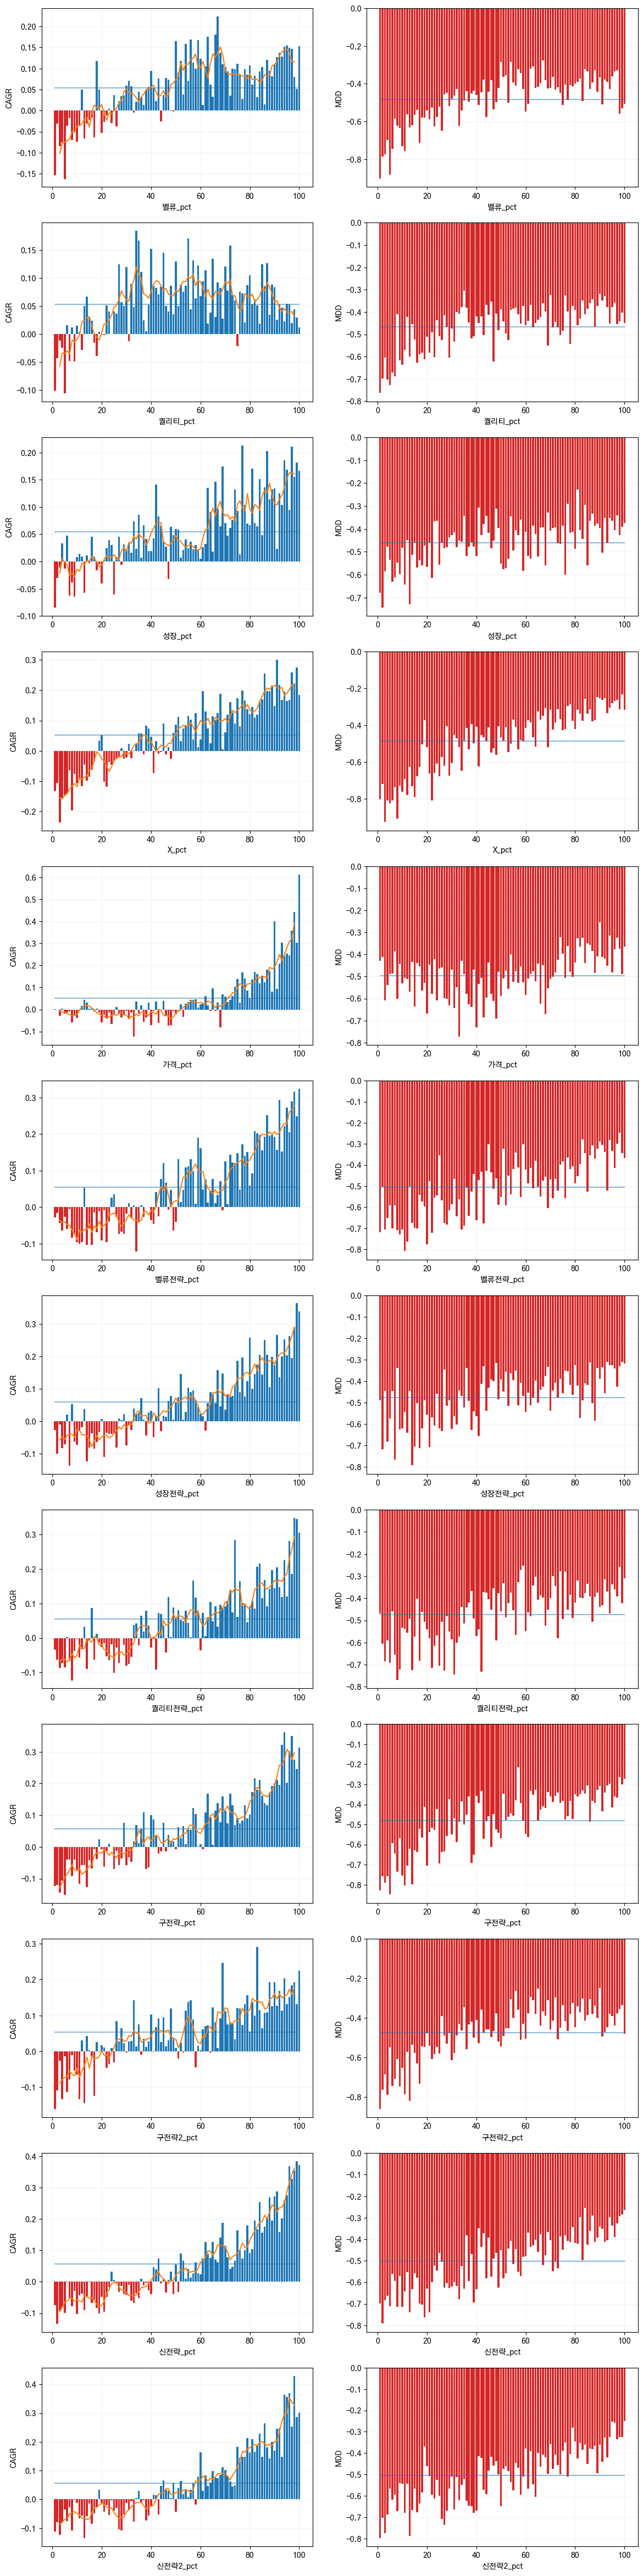

In [14]:
import matplotlib.pyplot as plt
from utils.quantutil import cagr as calc_cagr
from utils.quantutil import mdd as calc_mdd
from utils import pdutil

target_factors = list(recipes.keys())
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(14), fig.set_figheight(5 * len(target_factors))
summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = layer4[colname].dropna().sort_values().unique()
    cagr, mdd = [], []
    for pct in pcts:
        by_pct = layer4[layer4[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        cagr.append(calc_cagr(1, cumprod.iloc[-1], by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date for s in return_by_ym.index]
        mdd.append(calc_mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    pcts = pd.Series(pcts)
    cagr, mdd = pd.Series(cagr), pd.Series(mdd)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr, color=["tab:blue" if v > 0 else "tab:red" for v in cagr])
    ax1.plot(pd.Series(pcts), [cagr.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd, color=["tab:blue" if v > 0 else "tab:red" for v in mdd])
    ax2.plot(pd.Series(pcts), [mdd.mean() for _ in pd.Series(pcts)], alpha=0.5)

    pct_mean = pcts.mean()
    cagr_mean = cagr.mean()

    slope = sum((pcts - pct_mean) * (cagr * 100 - cagr_mean)) / sum((pcts - pct_mean) ** 2)
    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr}).corr(method="spearman")
    kendall = pd.DataFrame({colname: pcts, "CAGR": cagr}).corr(method="kendall")
    summary = pd.concat([
        summary,
        pd.Series({
            "slope": slope,
            "spearman": spearman[colname]["CAGR"],
            "kendall": kendall[colname]["CAGR"],
            "t10": cagr.tail(10).mean(),
            "h10": cagr.head(10).mean(),
            "t10-h10": cagr.tail(10).mean() - cagr.head(10).mean(),
            "mean": cagr.mean(),
            "median": cagr.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["slope"]

print(layer4["매수년월"].min(), layer4["매도년월"].max())
summary = summary.sort_values(by="strength", ascending=False)
summary = summary[pdutil.sort_columns(summary.columns, forward=["strength"])]
summary.to_csv(".analysis/summary.csv")
summary

In [15]:
# 백테스트

from utils.quantutil import cagr, mdd

_key = ["매수년월", "매도년월"]
benchmark = layer4.groupby(_key)["수익률"].mean()

strategy_name = "신전략"
print(strategy_name)

result2 = layer4.copy()[layer4[strategy_name].notna()]

# result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
# result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/R_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/R_pct"] > 10]
result2 = result2[result2["EBT/A_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["O/R_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["EBT/R_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["EBT/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]
result2 = result2[result2["퀄리티_pct"] > 10]

port_size = 40
port = result2.groupby(_key).apply(lambda x: x.sort_values(strategy_name, ascending=False).head(port_size))
strategy = port.reset_index(drop=True).groupby(_key)["수익률"].mean()
strategy = pd.Series(strategy, index=benchmark.index)

revisions = pd.DataFrame({
    "BM 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": strategy - benchmark,
    "BM 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod(),
})

running_max = revisions["BM 누적수익률"].cummax()
revisions["BM DD"] = (revisions["BM 누적수익률"] - running_max) / running_max

running_max = revisions["전략 누적수익률"].cummax()
revisions["전략 DD"] = (revisions["전략 누적수익률"] - running_max) / running_max

revisions = revisions.dropna()

years = len(revisions) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"].iloc[-1], years), cagr(1, revisions["BM 누적수익률"].iloc[-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions["전략 누적수익률"].index], revisions["전략 누적수익률"].tolist()),
            mdd([i2 for _, i2 in revisions.index], revisions["BM 누적수익률"].tolist())],
    "Mean": [revisions["전략 수익률"].mean(), revisions["BM 수익률"].mean()]
}, index=["전략", "BM"])
print(summary)

result3 = port.reset_index(drop=True).groupby(_key).apply(lambda x: x.sort_values("수익률", ascending=False))[[
    "code", "종목명", "수익률", "매수일", "매도일", "매수가", "매도가", "consolidated",
    "P_pct", "성장_pct", "벨류_pct", "퀄리티_pct", f"{strategy_name}_pct"
]]
result3 = result3.reset_index(drop=True)
result3.to_csv(".analysis/port.csv")
result3

신전략
        CAGR                                         MDD      Mean
전략  0.386269  (-0.24861569691636776, (2022-04, 2022-09))  0.030528
BM  0.057526   (-0.3674258518414856, (2018-05, 2020-03))  0.006622


,code,종목명,수익률,매수일,매도일,매수가,매도가,consolidated,P_pct,성장_pct,벨류_pct,퀄리티_pct,신전략_pct
0,005320,국동,0.553191,2014-04-30,2014-05-30,4700.0,7300.0,1.0,3.0,48.0,77.0,94.0,99.0
1,120030,조선선재,0.272158,2014-04-30,2014-05-30,47950.0,61000.0,0.0,23.0,99.0,53.0,88.0,96.0
2,092730,네오팜,0.258224,2014-04-30,2014-05-30,6080.0,7650.0,0.0,15.0,97.0,52.0,82.0,98.0
3,051630,진양화학,0.218310,2014-04-30,2014-05-30,2840.0,3460.0,0.0,8.0,90.0,60.0,85.0,99.0
4,038010,제일테크노스,0.216837,2014-04-30,2014-05-30,19600.0,23850.0,1.0,2.0,55.0,98.0,56.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,042940,상지카일룸,-0.077406,2023-10-31,2023-11-30,478.0,441.0,1.0,11.0,100.0,86.0,82.0,100.0
4596,020400,대동금속,-0.090717,2023-10-31,2023-11-30,9480.0,8620.0,0.0,2.0,87.0,74.0,49.0,99.0
4597,204020,그리티,-0.097004,2023-10-31,2023-11-30,3505.0,3165.0,1.0,22.0,89.0,79.0,98.0,99.0
4598,098660,에스티오,-0.135870,2023-10-31,2023-11-30,2760.0,2385.0,1.0,4.0,66.0,76.0,97.0,100.0


In [16]:
revisions.to_csv(".analysis/revisions.csv")
revisions

,,BM 수익률,전략 수익률,성능,BM 누적수익률,전략 누적수익률,BM DD,전략 DD
매수년월,매도년월,,,,,,,
2014-04,2014-05,-0.008505,0.024655,0.033160,0.991495,1.024655,0.000000,0.000000
2014-05,2014-06,-0.008698,0.009101,0.017798,0.982871,1.033980,-0.008698,0.000000
2014-06,2014-07,0.014296,0.050237,0.035941,0.996923,1.085924,0.000000,0.000000
2014-07,2014-08,0.040334,0.051144,0.010811,1.037132,1.141463,0.000000,0.000000
2014-08,2014-09,0.012084,0.079086,0.067002,1.049665,1.231737,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2023-06,2023-07,-0.027836,-0.071457,-0.043621,1.813266,23.294337,-0.243214,-0.071457
2023-07,2023-08,0.016717,0.020564,0.003847,1.843579,23.773366,-0.230563,-0.052362
2023-08,2023-09,-0.064116,-0.052449,0.011667,1.725376,22.526470,-0.279896,-0.102065


total            115.000000
out-perform       59.000000
under-perform      8.000000
승률                 0.756522
누적 성능             13.203130
dtype: float64

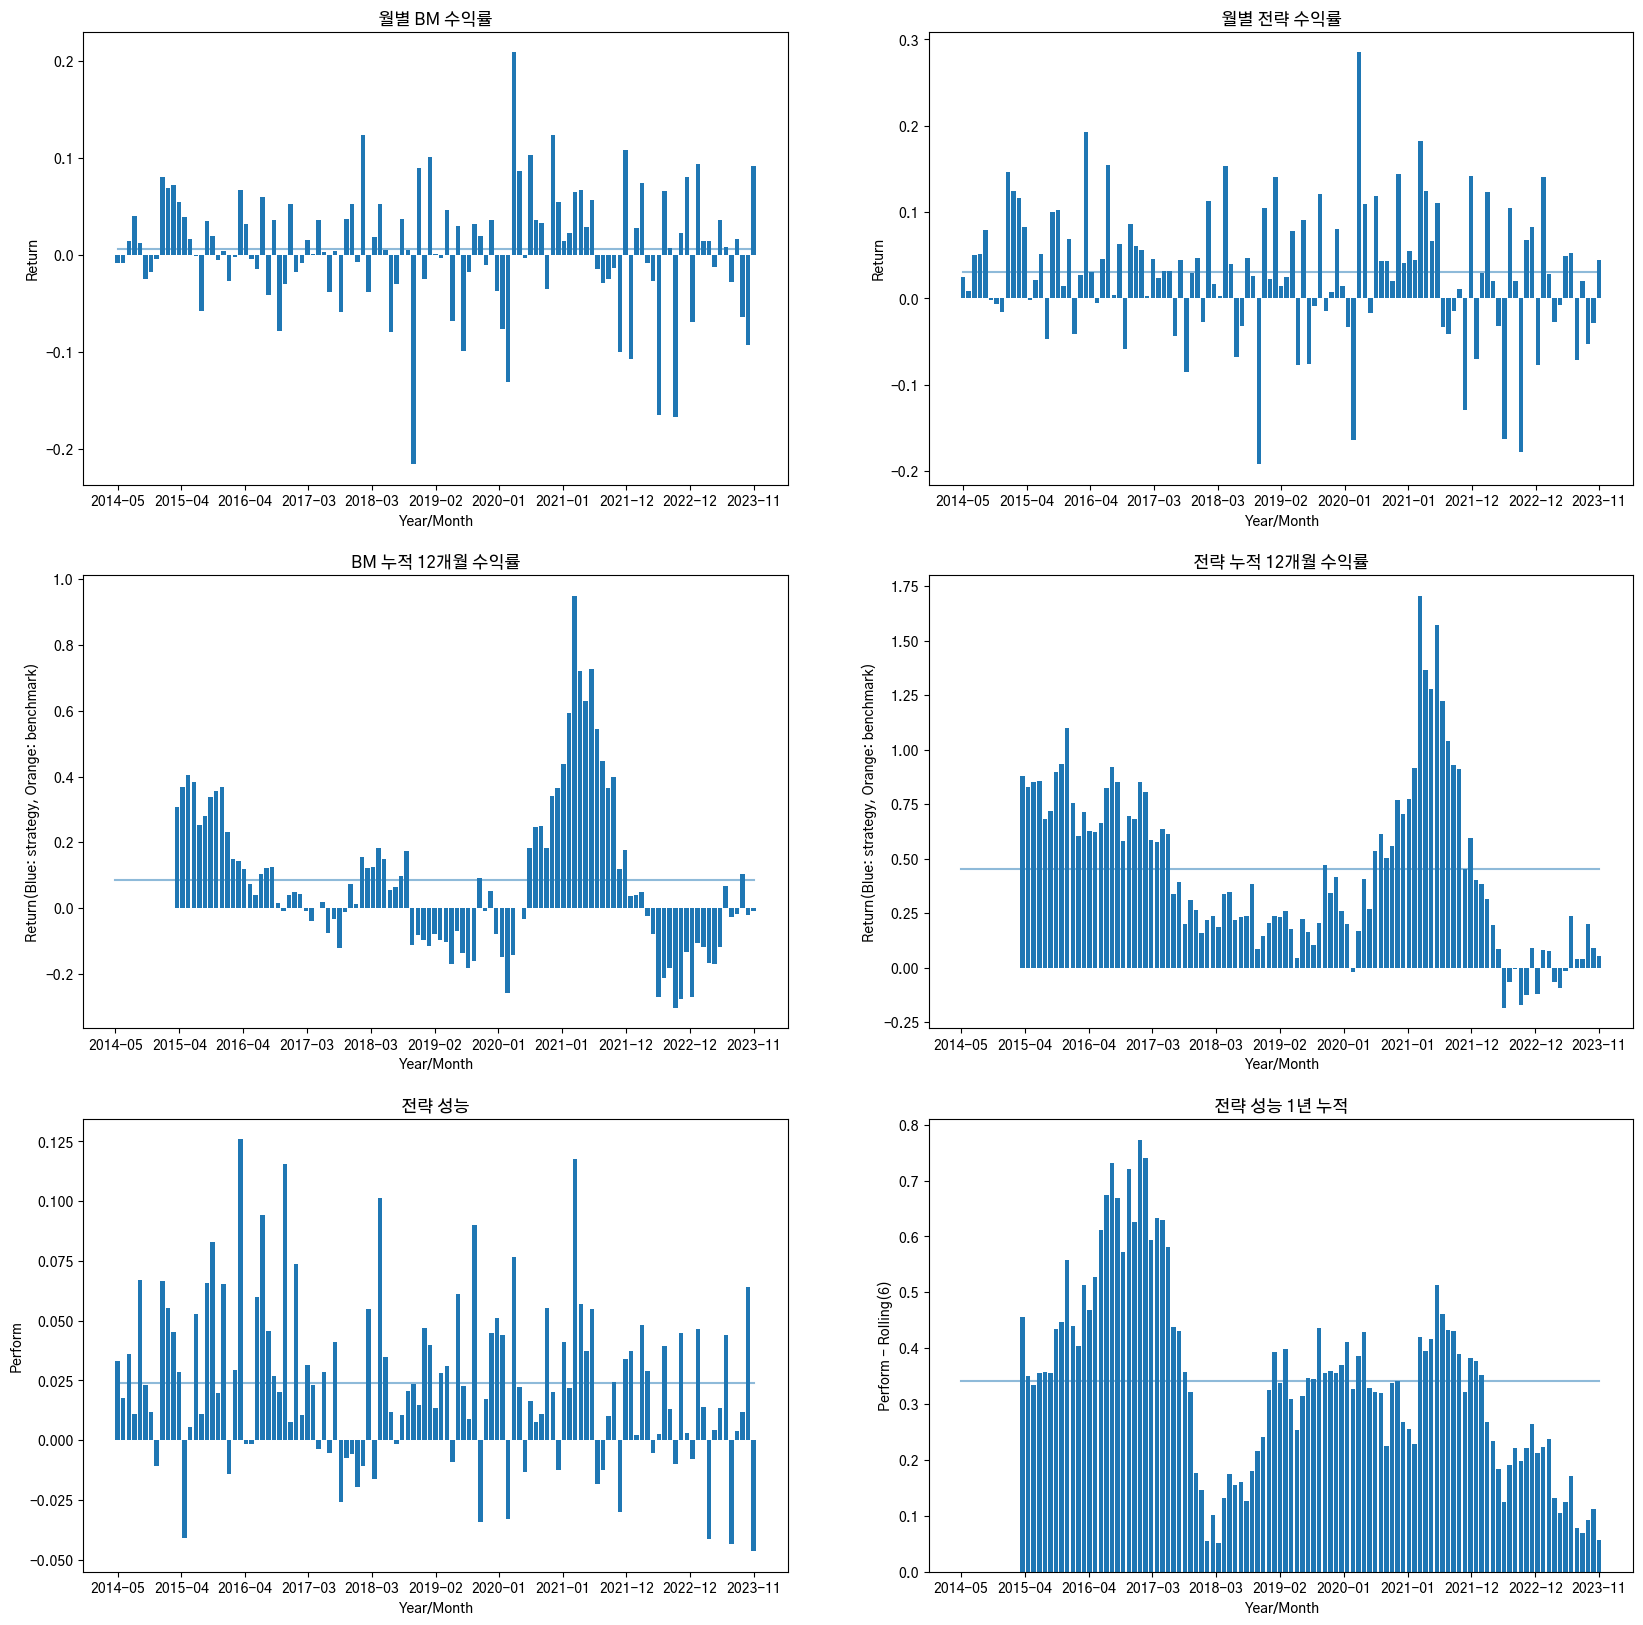

In [17]:
import numpy as np

months = [str(i) for _, i in revisions.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 BM 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["BM 수익률"])
ax1.plot(months, [revisions["BM 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"BM 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["BM 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "total": len(revisions),
    "out-perform": (revisions["성능"] > 0.02).sum(),
    "under-perform": (revisions["성능"] < -0.02).sum(),
    "승률": (revisions["성능"] > 0).sum() / len(revisions),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})

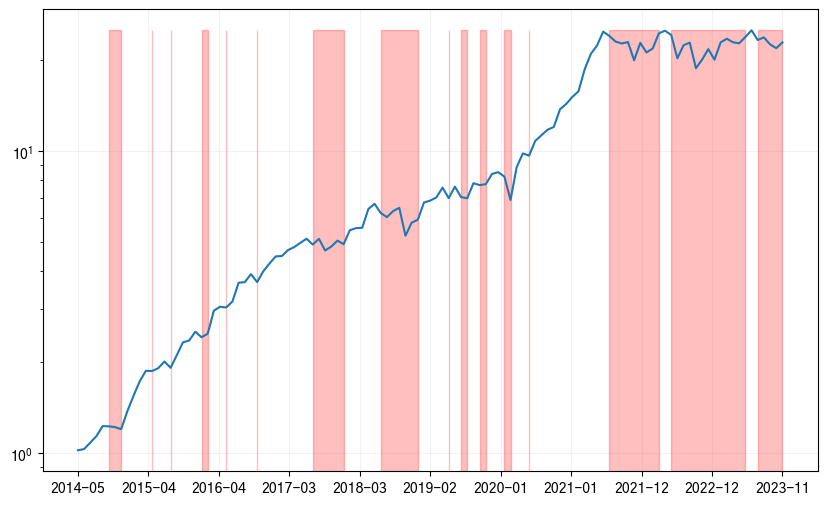

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 예시 생성
x_values = months
y_values = revisions["전략 누적수익률"]
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.yscale('log')
plt.xticks(np.quantile(np.arange(0, len(revisions)), xticks))
plt.grid(True)
plt.fill_between(
    x_values, y_values.max(),
    where=(revisions["전략 DD"] < 0),
    color="red", alpha=0.25
)